# Import the necessary libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# Helper functions

* Compare_performance() is a function that will print the classification report of the predictions on both the training and testing dataset
* Plot_fitted_tree() will display the full decision tree of an estimator

In [2]:
def compare_performance(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print("Training examples:")
    print(classification_report(y_train, train_preds))
    print('-'*50+'\n')
    print("Testing examples:")
    print(classification_report(y_test, test_preds))
    
def plot_fitted_tree(tree_model):
    plt.figure(figsize=(18,10))
    plot_tree(tree_model, 
              filled=True, 
              rounded=True, 
              class_names = ['Not Churned', 'Churned'], 
              feature_names = X_train.columns);
    
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cherr/Graphviz/bin'

# Ready the dataset

This notebook is not focused on data preprocessing, feature selection, or feature engineering. Normally, more due dilligence would be spent preparing the features but to keep the focus on classification trees I will keep the preprocessing to an absolute minimum.

This data features a number of customer characterstics involving their mobile usage. The target column is 'Churn', which is if the customer ceased buisness with the mobile provider.

In [3]:
train = pd.read_csv("churn-bigml-80.csv")
test = pd.read_csv("churn-bigml-20.csv")

train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


* Map category columns 'Churn', 'International plan', and 'Voice mail plan' to binary [0,1]
* Convert numeric column 'Voice mail messages' to binary [0 if 0, otherwise 1]
* Drop columns

In [4]:
for col in ['International plan', 'Voice mail plan']:
    train[col] = train[col].map({'Yes':1, 'No':0})
    test[col] = test[col].map({'Yes':1, 'No':0})
    
train['Voice mail messages'] = train['Number vmail messages'].apply(lambda x: 0 if x==0 else 1)
test['Voice mail messages'] = test['Number vmail messages'].apply(lambda x: 0 if x==0 else 1)

train['Churn'] = train['Churn'].map({False:0, True:1})
test['Churn'] = test['Churn'].map({False:0, True:1})

drop_cols = ['Area code', 
             'State',
             'Account length',
             'Total eve calls',
             'Total night calls',
             'Total day calls',
             'Total intl calls',
             'Number vmail messages']

train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [5]:
train.head()

,International plan,Voice mail plan,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total night minutes,Total night charge,Total intl minutes,Total intl charge,Customer service calls,Churn,Voice mail messages
0,0,1,265.1,45.07,197.4,16.78,244.7,11.01,10.0,2.70,1,0,1
1,0,1,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70,1,0,1
2,0,0,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29,0,0,0
3,1,0,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78,2,0,0
4,1,0,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73,3,0,0


In [6]:
X_train, y_train = train.drop('Churn', axis=1), train['Churn']
X_test, y_test = test.drop('Churn', axis=1), test['Churn']

# Decision Tree

The first model to build is a classic decision tree. This will utilize every example and feature in the training dataset. This will almost no-doubtedly overfit without any hyperparameter tuning.

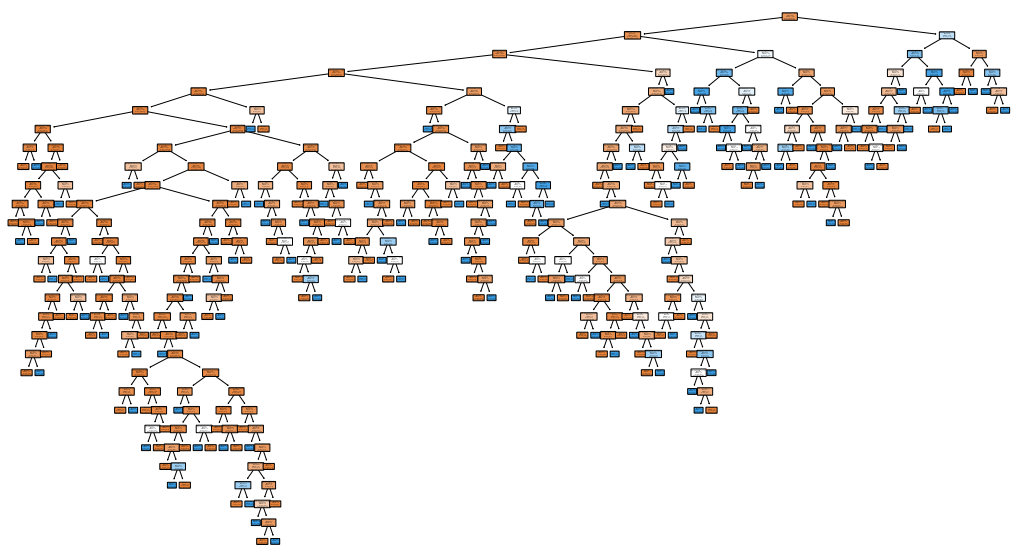

In [7]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

plot_fitted_tree(clf)

In [8]:
compare_performance(clf)

Training examples:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2278
           1       1.00      1.00      1.00       388

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666

--------------------------------------------------

Testing examples:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       572
           1       0.67      0.74      0.70        95

    accuracy                           0.91       667
   macro avg       0.81      0.84      0.82       667
weighted avg       0.91      0.91      0.91       667



The tree is huge! This would be nearly impossible to explain to a group of senior leaders. On top of that, our model is absolutely overfitting on the training data. We will keep track of the macro F1 score for this problem because of the target imbalance.

We can improve our high variance model by introducing a bit of bias (simplicity). We can do this by pruning our tree by choosing an optimal cost complexity alpha value.

In [9]:
clf = DecisionTreeClassifier()

params = {'ccp_alpha' : [0, .01, .02, .03]}

gs_clf = GridSearchCV(clf, params, cv=10).fit(X_train, y_train)

gs_clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.01)

Instead of searching for thousands and thousands of values for 'ccp_alpha', we have narrowed it down to a range between 0 and 0.02. Now we can drill down and search for the most optimal value in that range.

In [10]:
clf = DecisionTreeClassifier()

params = {'ccp_alpha' : np.linspace(0, .02, 1000)}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=10, 
                      scoring='neg_log_loss',
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.004364364364364364)

In [11]:
ccp_alpha = gs_clf.best_params_['ccp_alpha']
ccp_alpha

0.004364364364364364

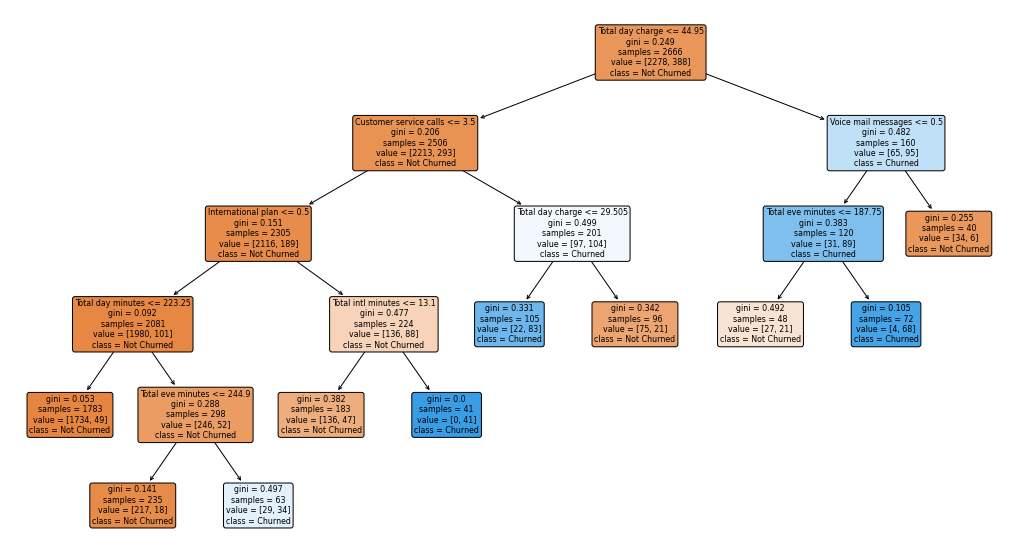

In [12]:
tree_clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha).fit(X_train, y_train)

plot_fitted_tree(tree_clf)

In [13]:
compare_performance(tree_clf)

Training examples:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2278
           1       0.80      0.58      0.68       388

    accuracy                           0.92      2666
   macro avg       0.87      0.78      0.81      2666
weighted avg       0.91      0.92      0.91      2666

--------------------------------------------------

Testing examples:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       572
           1       0.80      0.69      0.75        95

    accuracy                           0.93       667
   macro avg       0.88      0.83      0.85       667
weighted avg       0.93      0.93      0.93       667



The tree is so much easier to see! On top of that, we have greatly increased our macro F1 score on the test set. To make further improvements, we will build a random forest of decision trees.

# RandomForest

Random Forest is a bagging technique designed to help with the issue of overfitting. Here, we build independant decision trees using bootstrapped samples of the original dataset.

When a bootstrapped sample is taken with the same size as original, there will be approximitely 63% unique examples added in to the sample set, while the remaining 37% will be left out (called out-of-bag sample). You can utilize the out-of-bag sample for testing, which is out of the scope of this notebook.

Below is proof of the 63%/37% rule.

In [14]:
np.random.choice(range(1,11), 10)

array([3, 6, 1, 6, 9, 6, 8, 6, 7, 5])

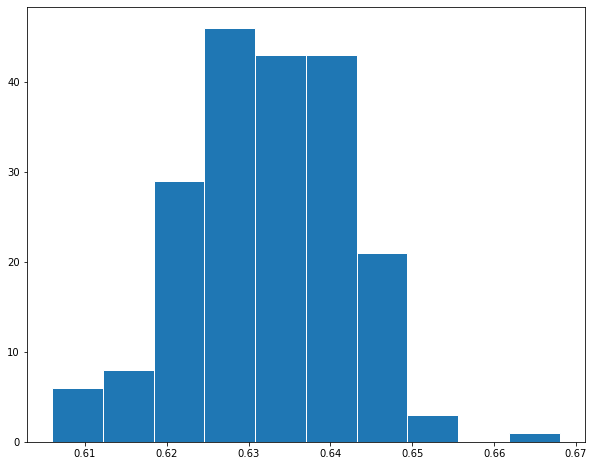

In [15]:
numbers = range(1, 1001)
percents = []

for _ in range(200):
    choices = np.random.choice(numbers, len(numbers))
    percent = len(np.unique(choices)) / len(numbers)
    percents.append(percent)
    
plt.figure(figsize=(10,8))
plt.hist(percents, edgecolor='white');

As you can see, between 61%-65% of examples will be used in the bootstrapped sample.

Below we can build the bagging classifier. We will use a decision tree classifier for each model in the bag, but you are free to use whatever model you wish. We will use the default value of for number of estimators in the bag, but we will tune that number later.

In [42]:
clf = RandomForestClassifier().fit(X_train, y_train)

compare_performance(clf)

Training examples:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2278
           1       1.00      1.00      1.00       388

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666

--------------------------------------------------

Testing examples:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       572
           1       0.91      0.72      0.80        95

    accuracy                           0.95       667
   macro avg       0.93      0.85      0.89       667
weighted avg       0.95      0.95      0.95       667



In [50]:
print("Train log-loss: {:.4f}".format(log_loss(y_train, clf.predict_proba(X_train))))
print("Test log-loss: {:.4f}".format(log_loss(y_test, clf.predict_proba(X_test))))

Train log-loss: 0.0486
Test log-loss: 0.2732


Right off the bat the performance is better than the decision tree on the test set. We are still overfitting. Let's see if we can tune the optimal number of estimators, max depth, and number of features so our model can generalize better.

First, I like to tune the proper number of trees. After getting the proper number of trees I tune the other parameters. Once the parameters are tuned I re check for a better value for number of trees.

In [19]:
clf = RandomForestClassifier(random_state=1)

params = {'n_estimators' : range(10, 251, 5)}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=7, 
                      scoring='neg_log_loss',
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

RandomForestClassifier(n_estimators=245, random_state=1)

In [20]:
clf = RandomForestClassifier(random_state=1)

params = {'n_estimators' : range(241, 250)}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=7, 
                      scoring='neg_log_loss',
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

RandomForestClassifier(n_estimators=245, random_state=1)

Now we have the proper number of estimators (245) we can tune the rest of the parameters.

In [23]:
clf = RandomForestClassifier(n_estimators=245, random_state=1)

params = {'max_depth' : range(4, 7, 8), 
          'class_weight' : ['balanced', 'balanced_subsample', None],
          'max_features' : ['sqrt', 'log2']}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=10, 
                      scoring='neg_log_loss',
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=245,
                       random_state=1)

In [24]:
gs_clf.best_params_

{'class_weight': None, 'max_depth': 4, 'max_features': 'sqrt'}

Class weight=None and max_features='sqrt' are default values, so we can ignore them.

In [25]:
clf = RandomForestClassifier(n_estimators=245, random_state=1)

params = {'max_depth' : range(2, 6)}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=10, 
                      scoring='neg_log_loss',
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=245, random_state=1)

Now that we have max_depth, lets search again for the optimal number of trees/estimators.

In [32]:
clf = RandomForestClassifier(random_state=1, max_depth=5)

params = {'n_estimators' : range(1, 351)}

gs_clf = GridSearchCV(clf, 
                      params, 
                      cv=7, 
                      scoring='neg_log_loss',
                      return_train_score=True,
                      n_jobs=-1).fit(X_train, y_train)

gs_clf.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=314, random_state=1)

''

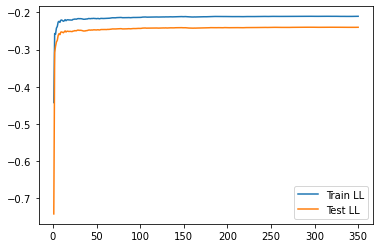

In [33]:
plt.plot(range(1, 351), gs_clf.cv_results_['mean_train_score'], label='Train LL')
plt.plot(range(1, 351), gs_clf.cv_results_['mean_test_score'], label='Test LL')
plt.legend()
;

In [34]:
n_estimators = gs_clf.best_params_['n_estimators']
n_estimators

314

In [51]:
rf_clf = RandomForestClassifier(random_state=1, max_depth=5, n_estimators=n_estimators).fit(X_train, y_train)

compare_performance(rf_clf)

Training examples:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      2278
           1       1.00      0.58      0.73       388

    accuracy                           0.94      2666
   macro avg       0.97      0.79      0.85      2666
weighted avg       0.94      0.94      0.93      2666

--------------------------------------------------

Testing examples:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       572
           1       0.95      0.56      0.70        95

    accuracy                           0.93       667
   macro avg       0.94      0.78      0.83       667
weighted avg       0.93      0.93      0.92       667



In [53]:
print("Train log-loss: {:.4f}".format(log_loss(y_train, rf_clf.predict_proba(X_train))))
print("Test log-loss: {:.4f}".format(log_loss(y_test, rf_clf.predict_proba(X_test))))

Train log-loss: 0.2130
Test log-loss: 0.2193


We have not improved our F1 score, however our log-loss has greatly improved, meaning our model is more confident in its predictions. Our training and testing F1 and log-loss is very close, meaning our model should be able to generalize very well.

Since we have over 300 trees, we cannot plot every one of them. We can, however, plot the individual trees using estimators_.

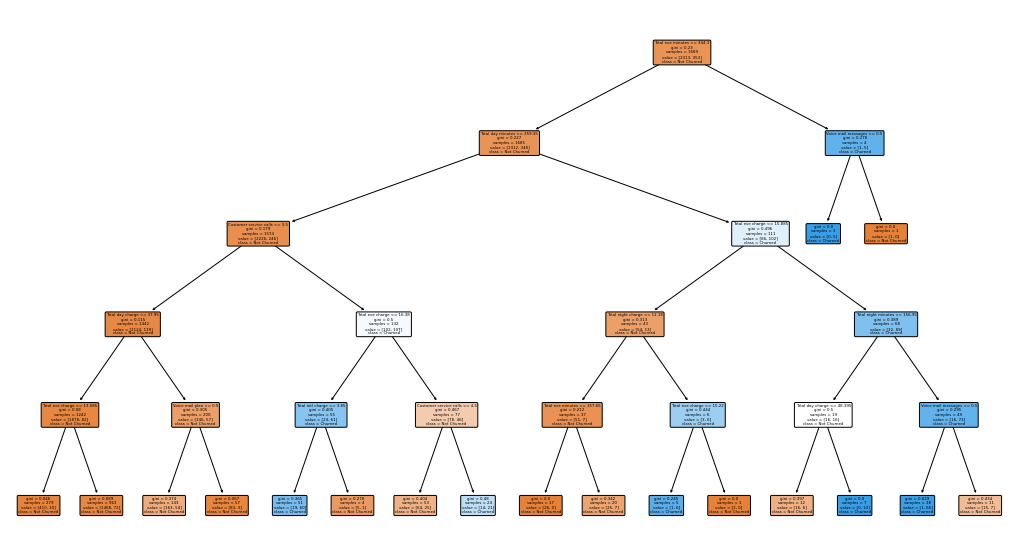

In [38]:
plot_fitted_tree(rf_clf.estimators_[0])

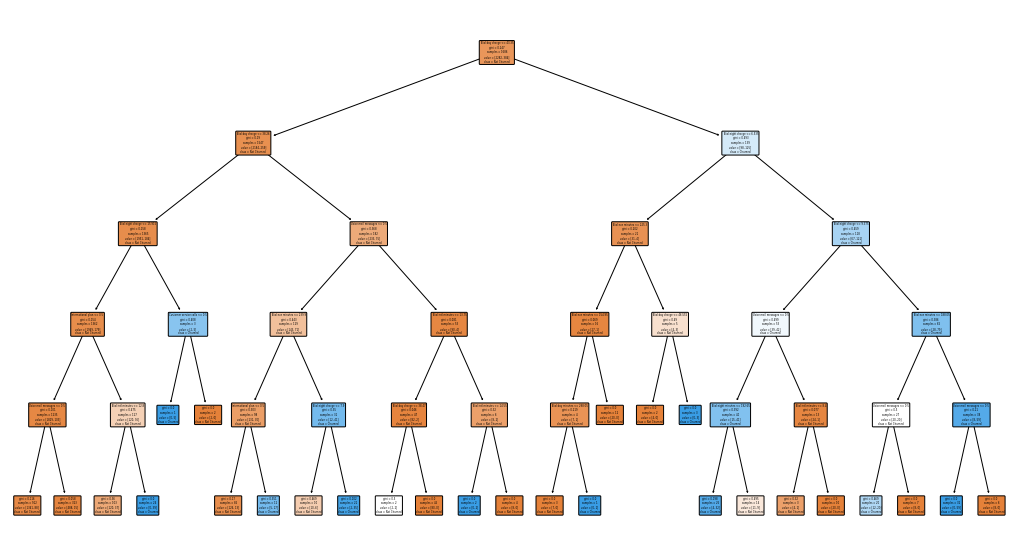

In [41]:
plot_fitted_tree(rf_clf.estimators_[-1])

# Model Comparison

We can now compare the two models.

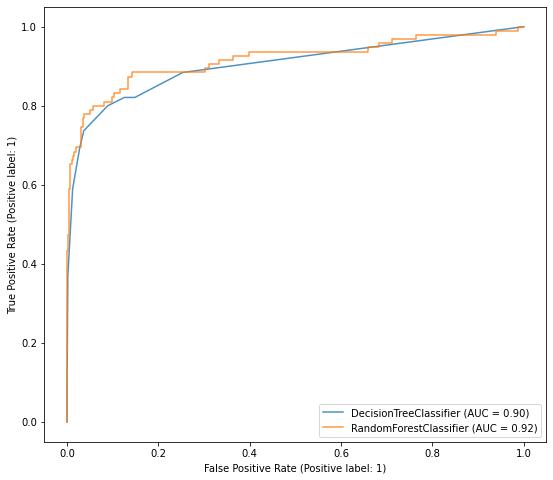

''

In [54]:
plt.figure(figsize=(9,8))
ax = plt.gca()

for model in [tree_clf, rf_clf]:
    disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
    
plt.show()
;

The AUC is very close, but the Random Forest just barely edges out our pruned Decision Tree. This does not mean the Decision Tree is useless! Since it is a small, pruned tree, we can easily present it to senior leadership. Traversing down a tree is simple to explain and easy for anyone to grasp the main ideas.

# Feature Importance

There are two ways to get feature importances from a Random Forest. First we will look at impurity based measures. This is the typical way of getting feature importance. In this method, you measure the average improvement on impurity on each feature split.

In [55]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

''

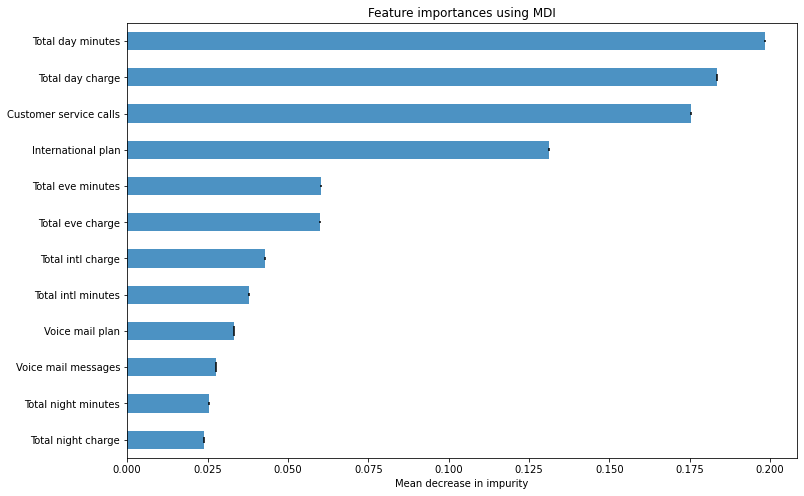

In [72]:
forest_importances = pd.Series(importances, index=X_test.columns).sort_values(ascending=True)

plt.figure(figsize=(12,8))
forest_importances.plot.barh(yerr=std, alpha=.8)
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
;

The top 3 features are 'Total day minutes', 'Total day charge', and 'Customer service calls'. These features, on average, produced the most improvement on impurity when creating each tree in the forest.

The second method of feature importance is through permutation. This method of prefered if you have features with high cardinality.

In [74]:
result = permutation_importance(rf_clf, X_test, y_test, n_repeats=50, random_state=1, n_jobs=-1)

''

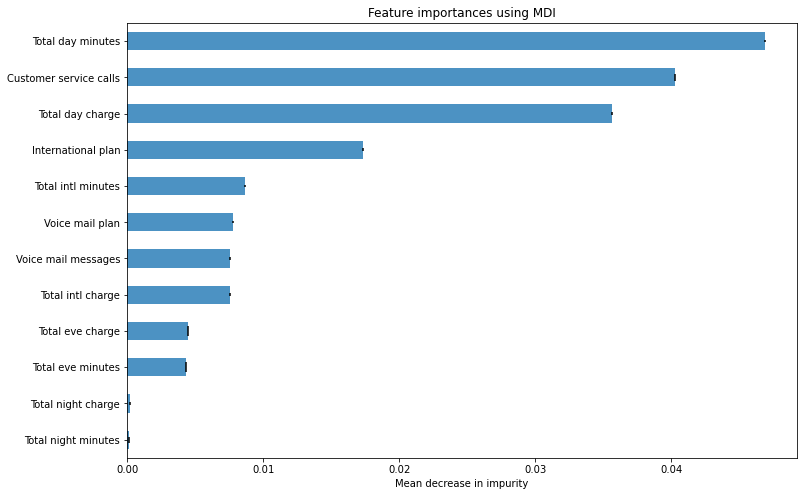

In [75]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=True)

plt.figure(figsize=(12,8))
forest_importances.plot.barh(yerr=std, alpha=.8)
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
;

'Total day minutes' is still the most important variable, however 'Custmomer service calls' and 'total day charge' have swapped. It is also important to note that two feature importances have shrunk and are very close to zero.

# End